---

# Customer Churn Prediction with SparkML
**EPITA – MSc Artificial Intelligence Systems (AIS)**  
**Spark & Python for Big Data AIS S2 F25**

**Students:** 
- TRUONG Kim Tan
- LE Linh Long
- George
- Farouk RAHAL

---

## Phase 1: Setup and Data Loading

In [1]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [3]:
from pyspark.sql.types import DoubleType, IntegerType
import pyspark.sql.functions as F

### 1.1. Iniialize SparkSession

In [4]:
spark = SparkSession.builder \
    .appName("ChurnPredictionPipeline") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

print(spark)

### 1.2. Load the Dataset

In [5]:
temp_df = pd.read_csv("C:/Users/pc/Desktop/Epita Msc AIS 1/AIS S2/Spark and python for big data/project 1/customer-churn-sparkml/WA_Fn-UseC_-Telco-Customer-Churn.csv", nrows=1)
cols = temp_df.columns.tolist()

# build schema
schema = StructType([StructField(c, StringType(), True) for c in cols])

pdf = pd.read_csv("C:/Users/pc/Desktop/Epita Msc AIS 1/AIS S2/Spark and python for big data/project 1/customer-churn-sparkml/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = spark.createDataFrame(pdf)
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: long (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: long (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



### 1.3. Initial Data Inspection

In [6]:
print(f"Total rows: {df.count()}")
df.printSchema()
df.show()

Total rows: 7043
root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: long (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: long (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)

+----------+------+-------------+-------+----------+------+-----------

---

## Phase 2: Exploratory Data Analysis (EDA) & Data Cleaning

### 2.1. Data Cleaning (Handling Missing Values)

**a) Column count check for Missing Values**

In [7]:
def count_missing(c, dtype):
    if isinstance(dtype, StringType):
        return F.count(
            F.when(
                F.col(c).isNull() | (F.trim(F.col(c)) == ""), 
                c
            )
        ).alias(c)
    else:
        return F.count(F.when(F.col(c).isNull(), c)).alias(c)

missing_counts = df.select([
    count_missing(c, dtype) for c, dtype in df.dtypes
])

missing_data = missing_counts.collect()[0].asDict()

print(f"{'Column':<20} {'Missing Count':>15}")
print("-" * 40)
for col_name, count in missing_data.items():
    print(f"{col_name:<20} {count:>15}")

Column                 Missing Count
----------------------------------------
customerID                         0
gender                             0
SeniorCitizen                      0
Partner                            0
Dependents                         0
tenure                             0
PhoneService                       0
MultipleLines                      0
InternetService                    0
OnlineSecurity                     0
OnlineBackup                       0
DeviceProtection                   0
TechSupport                        0
StreamingTV                        0
StreamingMovies                    0
Contract                           0
PaperlessBilling                   0
PaymentMethod                      0
MonthlyCharges                     0
TotalCharges                       0
Churn                              0


**b) Data Cleaning**

In [8]:

# Handle TotalCharges: replace empty strings with null, then cast to Double
df = df.withColumn('TotalCharges', 
                   F.when(F.col('TotalCharges').isin("", " "), None)
                   .otherwise(F.col('TotalCharges')))

# Drop rows with null TotalCharges (11 records)
print(f"\nRows before dropping null TotalCharges: {df.count()}")
df_clean = df.na.drop(subset=['TotalCharges'])
print(f"Rows after dropping null TotalCharges: {df_clean.count()}")

# Check for duplicates
print(f"\nDuplicate customerID count: {df_clean.count() - df_clean.select('customerID').distinct().count()}")


Rows before dropping null TotalCharges: 7043
Rows after dropping null TotalCharges: 7032

Duplicate customerID count: 0


### 2.2. Data preparation

In [9]:
df_clean = df_clean.withColumn('TotalCharges', F.col('TotalCharges').cast(DoubleType()))

# Cast SeniorCitizen to Integer (here the values are currently "0", "1")
df_clean = df_clean.withColumn('SeniorCitizen', F.col('SeniorCitizen').cast(IntegerType()))

# Cast tenure to Integer
df_clean = df_clean.withColumn('tenure', F.col('tenure').cast(IntegerType()))

# Cast MonthlyCharges to Double
df_clean = df_clean.withColumn('MonthlyCharges', F.col('MonthlyCharges').cast(DoubleType()))

print("Schema after conversion of columns:")
df_clean.printSchema()

Schema after conversion of columns:
root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



### 2.3. Univariate Analysis (Analyzing Single Variables)

**a) Numerical Features**

In [10]:
# numerical columns summary
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_clean.select(numerical_cols).describe().show()

# SeniorCitizen belongs to categorical column
print("SeniorCitizen Distribution:")
df_clean.groupBy('SeniorCitizen').count().show()

+-------+------------------+-----------------+------------------+
|summary|            tenure|   MonthlyCharges|      TotalCharges|
+-------+------------------+-----------------+------------------+
|  count|              7032|             7032|              7032|
|   mean|32.421786120591584|64.79820819112626|2283.3004408418656|
| stddev|24.545259709263256|30.08597388404984| 2266.771361883145|
|    min|                 1|            18.25|              18.8|
|    max|                72|           118.75|            8684.8|
+-------+------------------+-----------------+------------------+

SeniorCitizen Distribution:
+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|            0| 5890|
|            1| 1142|
+-------------+-----+



**b) Categorical Features**

In [11]:
categorical_cols = [c for c in df_clean.columns if c not in numerical_cols + ['customerID', 'SeniorCitizen']]
print(f"Categorical columns: {categorical_cols}")

# Show value counts for key categorical columns
key_categorical = ['gender', 'Partner', 'Dependents', 'Contract', 
                   'InternetService', 'PaymentMethod', 'Churn']

for col in key_categorical:
    print(f"{col} distribution:")
    df_clean.groupBy(col).count().orderBy(F.desc('count')).show()

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
gender distribution:
+------+-----+
|gender|count|
+------+-----+
|  Male| 3549|
|Female| 3483|
+------+-----+

Partner distribution:
+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3639|
|    Yes| 3393|
+-------+-----+

Dependents distribution:
+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2099|
+----------+-----+

Contract distribution:
+--------------+-----+
|      Contract|count|
+--------------+-----+
|Month-to-month| 3875|
|      Two year| 1685|
|      One year| 1472|
+--------------+-----+

InternetService distribution:
+---------------+-----+
|InternetService|count|
+---------------+-----+
|    Fiber optic| 3096|
|            DSL| 2416|
|             No| 1520|


### 2.4. Bivariate Analysis (Analyzing Relationships)

In [12]:
print("Churn rate by Contract type:")
df_clean.groupBy('Contract').agg(
    F.count('*').alias('total'),
    F.sum(F.when(F.col('Churn') == 'Yes', 1).otherwise(0)).alias('churned'),
    (F.sum(F.when(F.col('Churn') == 'Yes', 1).otherwise(0)) / F.count('*') * 100).alias('churn_rate')
).show()

print("Churn rate by Internet Service:")
df_clean.groupBy('InternetService').agg(
    F.count('*').alias('total'),
    F.sum(F.when(F.col('Churn') == 'Yes', 1).otherwise(0)).alias('churned'),
    (F.sum(F.when(F.col('Churn') == 'Yes', 1).otherwise(0)) / F.count('*') * 100).alias('churn_rate')
).show()

# Tenure statistics by Churn
print("Tenure statistics by Churn:")
df_clean.groupBy('Churn').agg(
    F.avg('tenure').alias('avg_tenure'),
    F.min('tenure').alias('min_tenure'),
    F.max('tenure').alias('max_tenure'),
    F.avg('MonthlyCharges').alias('avg_monthly_charges'),
    F.avg('TotalCharges').alias('avg_total_charges')
).show()

Churn rate by Contract type:
+--------------+-----+-------+------------------+
|      Contract|total|churned|        churn_rate|
+--------------+-----+-------+------------------+
|Month-to-month| 3875|   1655| 42.70967741935484|
|      One year| 1472|    166|11.277173913043478|
|      Two year| 1685|     48|2.8486646884272995|
+--------------+-----+-------+------------------+

Churn rate by Internet Service:
+---------------+-----+-------+------------------+
|InternetService|total|churned|        churn_rate|
+---------------+-----+-------+------------------+
|             No| 1520|    113| 7.434210526315789|
|            DSL| 2416|    459|18.998344370860927|
|    Fiber optic| 3096|   1297| 41.89276485788114|
+---------------+-----+-------+------------------+

Tenure statistics by Churn:
+-----+------------------+----------+----------+-------------------+-----------------+
|Churn|        avg_tenure|min_tenure|max_tenure|avg_monthly_charges|avg_total_charges|
+-----+------------------+--

---

## Phase 3: Data Transformation & Feature Engineering

### 3.1. Identify Feature Columns

In [13]:
# we identify feature columns (except for customerID and target)
feature_cols = [c for c in df_clean.columns if c not in ['customerID', 'Churn']]

# we separate columns into categorical and numerical
cat_cols = [c for c in feature_cols if c not in numerical_cols]
num_cols = [c for c in feature_cols if c in numerical_cols]

print(f"Features to use: {feature_cols}")
print(f"Categorical: {cat_cols}")
print(f"Numerical: {num_cols}")

# we convert the target variable to numeric
df_clean = df_clean.withColumn('label', F.when(F.col('Churn') == 'Yes', 1).otherwise(0))

Features to use: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
Categorical: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical: ['tenure', 'MonthlyCharges', 'TotalCharges']


### 3.2. Define Pipeline Stages

**a) Categorical Encoding**

In [14]:
indexers = []
encoders = []
indexed_cols = []
encoded_cols = []

for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep')
    encoder = OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_encoded", dropLast=False)
    indexers.append(indexer)
    encoders.append(encoder)
    indexed_cols.append(f"{col}_indexed")
    encoded_cols.append(f"{col}_encoded")

**b) Vector Assembly**

In [15]:
# combine numerical features with encoded categorical features
assembler_inputs = num_cols + encoded_cols
vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features_unscaled')

**c) Feature Scaling**

In [16]:
scaler = StandardScaler(inputCol='features_unscaled', outputCol='features', 
                        withStd=True, withMean=True)

**d) Create Pipeline**

In [17]:
pipeline_stages = indexers + encoders + [vector_assembler, scaler]
pipeline = Pipeline(stages=pipeline_stages)

print(f"Pipeline stages: {len(indexers)} indexers, {len(encoders)} encoders, 1 assembler, 1 scaler")
print(f"Total stages in pipeline: {len(pipeline_stages)}")

Pipeline stages: 16 indexers, 16 encoders, 1 assembler, 1 scaler
Total stages in pipeline: 34


---

---

## Phase 4: Building the ML Pipeline

*Now we assemble all transformation stages along with a classification model into a single `Pipeline` object.*

### 4.1. Define the Model

We use `LogisticRegression` as our baseline classifier — it is simple, interpretable, and well-suited for binary classification tasks like churn prediction.

In [18]:
lr = LogisticRegression(
    featuresCol='features',
    labelCol='label',
    maxIter=10,
    regParam=0.01,
    elasticNetParam=0.0
)
print("LogisticRegression model defined.")

LogisticRegression model defined.


### 4.2. Assemble the Full Pipeline

We chain all stages in order: StringIndexers → OneHotEncoders → VectorAssembler → StandardScaler → LogisticRegression.

In [19]:
pipeline = Pipeline(stages=indexers + encoders + [vector_assembler, scaler, lr])

print("Pipeline created successfully with the following stages:")
for i, stage in enumerate(pipeline.getStages()):
    print(f"  {i+1}. {stage.__class__.__name__}")

Pipeline created successfully with the following stages:
  1. StringIndexer
  2. StringIndexer
  3. StringIndexer
  4. StringIndexer
  5. StringIndexer
  6. StringIndexer
  7. StringIndexer
  8. StringIndexer
  9. StringIndexer
  10. StringIndexer
  11. StringIndexer
  12. StringIndexer
  13. StringIndexer
  14. StringIndexer
  15. StringIndexer
  16. StringIndexer
  17. OneHotEncoder
  18. OneHotEncoder
  19. OneHotEncoder
  20. OneHotEncoder
  21. OneHotEncoder
  22. OneHotEncoder
  23. OneHotEncoder
  24. OneHotEncoder
  25. OneHotEncoder
  26. OneHotEncoder
  27. OneHotEncoder
  28. OneHotEncoder
  29. OneHotEncoder
  30. OneHotEncoder
  31. OneHotEncoder
  32. OneHotEncoder
  33. VectorAssembler
  34. StandardScaler
  35. LogisticRegression


---

## Phase 5: Model Training and Evaluation

*We split the data, train the full pipeline on the training set, make predictions on the test set, and measure performance.*

### 5.1. Split the Data

We split `df_clean` into 80% training and 20% testing using `randomSplit`, with a fixed seed for reproducibility.

In [20]:
train_df, test_df = df_clean.randomSplit([0.8, 0.2], seed=42)

print(f"Training set : {train_df.count()} records")
print(f"Test set     : {test_df.count()} records")

print("\nClass distribution in training set:")
train_df.groupBy('label').count().orderBy('label').show()

Training set : 5646 records
Test set     : 1386 records

Class distribution in training set:
+-----+-----+
|label|count|
+-----+-----+
|    0| 4153|
|    1| 1493|
+-----+-----+



### 5.2. Train the Model

We call `.fit()` on the pipeline with the training data. Spark will execute all stages in order: learn string-index mappings, fit the scaler, and train the logistic regression.

In [21]:
model = pipeline.fit(train_df)
print("Model trained successfully.")

Model trained successfully.


### 5.3. Make Predictions and Evaluate

We apply the fitted `PipelineModel` to the test set and evaluate with Accuracy, F1, Precision, Recall, AUC-ROC, and a Confusion Matrix.

In [22]:
# Make predictions
predictions = model.transform(test_df)

print("Sample predictions (top 10):")
predictions.select('customerID', 'Churn', 'label', 'prediction', 'probability') \
           .show(10, truncate=False)

Sample predictions (top 10):
+----------+-----+-----+----------+-----------------------------------------+
|customerID|Churn|label|prediction|probability                              |
+----------+-----+-----+----------+-----------------------------------------+
|0104-PPXDV|No   |0    |0.0       |[0.9539926126924685,0.04600738730753151] |
|0177-PXBAT|No   |0    |0.0       |[0.5549302458720609,0.44506975412793914] |
|0206-TBWLC|No   |0    |0.0       |[0.881784125902092,0.11821587409790801]  |
|0256-LTHVJ|Yes  |1    |0.0       |[0.5069815617868784,0.49301843821312163] |
|0303-UNCIP|No   |0    |0.0       |[0.8733001267279747,0.12669987327202525] |
|0318-ZOPWS|No   |0    |0.0       |[0.978987217220773,0.021012782779227024] |
|0404-SWRVG|Yes  |1    |1.0       |[0.2803043060032534,0.7196956939967466]  |
|0513-RBGPE|No   |0    |0.0       |[0.970351155868915,0.02964884413108504]  |
|0731-EBJQB|No   |0    |0.0       |[0.9613491088731548,0.038650891126845166]|
|0732-OCQOC|No   |0    |0.0       |

In [23]:
# ── Accuracy ──
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator_acc.evaluate(predictions)

# ── F1 Score ──
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='f1')
f1_score = evaluator_f1.evaluate(predictions)

# ── Precision ──
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='weightedPrecision')
precision = evaluator_precision.evaluate(predictions)

# ── Recall ──
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='weightedRecall')
recall = evaluator_recall.evaluate(predictions)

# ── AUC-ROC ──
evaluator_auc = BinaryClassificationEvaluator(
    labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC')
auc = evaluator_auc.evaluate(predictions)

print("-" * 40)
print(f"Test Accuracy  = {accuracy:.4f}")
print(f"Test F1 Score  = {f1_score:.4f}")
print(f"Test Precision = {precision:.4f}")
print(f"Test Recall    = {recall:.4f}")
print(f"AUC-ROC        = {auc:.4f}")
print("-" * 40)

print("\nConfusion Matrix:")
predictions.groupBy('label', 'prediction').count().orderBy('label', 'prediction').show()

----------------------------------------
Test Accuracy  = 0.7900
Test F1 Score  = 0.7822
Test Precision = 0.7798
Test Recall    = 0.7900
AUC-ROC        = 0.8386
----------------------------------------

Confusion Matrix:
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|  902|
|    0|       1.0|  108|
|    1|       0.0|  183|
|    1|       1.0|  193|
+-----+----------+-----+



---

## Phase 5B: Advanced Model — GBTClassifier with Hyperparameter Tuning

*As a next step beyond Logistic Regression, we train a **Gradient Boosted Trees (GBT)** classifier.*  
*GBT builds trees sequentially — each tree corrects the errors of the previous one — making it much more powerful on non-linear tabular data like churn.*  

*We also apply **CrossValidator** to automatically find the best hyperparameter configuration via 5-fold cross-validation.*

### 5B.1. Imports

In [24]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

print("GBT and CrossValidator imports ready.")

GBT and CrossValidator imports ready.


### 5B.2. Define the GBT Model

Key GBT hyperparameters we will tune:
- **`maxIter`** — number of boosting rounds (trees)
- **`maxDepth`** — depth of each individual tree
- **`stepSize`** — learning rate (how much each tree contributes)

> **Note:** GBT in SparkML does **not** use `StandardScaler` features — tree-based models are scale-invariant.  
> We rebuild the preprocessing pipeline **without** the scaler for GBT.

In [25]:
# GBT does not need scaled features — rebuild assembler output directly
from pyspark.ml.feature import VectorAssembler

# New assembler: outputs 'features_gbt' (unscaled)
assembler_gbt = VectorAssembler(
    inputCols=num_cols + encoded_cols,
    outputCol='features_gbt'
)

gbt = GBTClassifier(
    featuresCol='features_gbt',
    labelCol='label',
    maxIter=50,        # default, will be tuned
    maxDepth=5,        # default, will be tuned
    stepSize=0.1,      # learning rate, will be tuned
    seed=42
)

print("GBTClassifier defined.")

GBTClassifier defined.


### 5B.3. Assemble the GBT Pipeline

Stages: StringIndexers → OneHotEncoders → VectorAssembler (unscaled) → GBTClassifier.

In [26]:
pipeline_gbt = Pipeline(
    stages=indexers + encoders + [assembler_gbt, gbt]
)

print("GBT Pipeline stages:")
for i, stage in enumerate(pipeline_gbt.getStages()):
    print(f"  {i+1}. {stage.__class__.__name__}")

GBT Pipeline stages:
  1. StringIndexer
  2. StringIndexer
  3. StringIndexer
  4. StringIndexer
  5. StringIndexer
  6. StringIndexer
  7. StringIndexer
  8. StringIndexer
  9. StringIndexer
  10. StringIndexer
  11. StringIndexer
  12. StringIndexer
  13. StringIndexer
  14. StringIndexer
  15. StringIndexer
  16. StringIndexer
  17. OneHotEncoder
  18. OneHotEncoder
  19. OneHotEncoder
  20. OneHotEncoder
  21. OneHotEncoder
  22. OneHotEncoder
  23. OneHotEncoder
  24. OneHotEncoder
  25. OneHotEncoder
  26. OneHotEncoder
  27. OneHotEncoder
  28. OneHotEncoder
  29. OneHotEncoder
  30. OneHotEncoder
  31. OneHotEncoder
  32. OneHotEncoder
  33. VectorAssembler
  34. GBTClassifier


### 5B.4. Define the Parameter Grid & CrossValidator

We search over a grid of `maxIter`, `maxDepth`, and `stepSize` combinations.  
CrossValidator runs **5-fold cross-validation** on each combination and selects the best.

| Parameter | Values tested |
|---|---|
| `maxIter` | 20, 50 |
| `maxDepth` | 3, 5 |
| `stepSize` | 0.05, 0.1 |

> This grid = 2 × 2 × 2 = **8 combinations × 5 folds = 40 Spark jobs**. Expect ~3–6 minutes on a local machine.

In [27]:
# Build parameter grid
paramGrid = (
    ParamGridBuilder()
    .addGrid(gbt.maxIter,   [20, 50])
    .addGrid(gbt.maxDepth,  [3, 5])
    .addGrid(gbt.stepSize,  [0.05, 0.1])
    .build()
)

print(f"Total parameter combinations to evaluate: {len(paramGrid)}")

# AUC-ROC evaluator — best metric for imbalanced binary classification
cv_evaluator = BinaryClassificationEvaluator(
    labelCol='label',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

# CrossValidator
cv = CrossValidator(
    estimator=pipeline_gbt,
    estimatorParamMaps=paramGrid,
    evaluator=cv_evaluator,
    numFolds=5,
    seed=42,
    parallelism=2      # run 2 folds in parallel to speed things up
)

print("CrossValidator configured with 5-fold CV.")

Total parameter combinations to evaluate: 8
CrossValidator configured with 5-fold CV.


### 5B.5. Train the CrossValidator

This fits the entire pipeline for every parameter combination across every fold.  
The best model is accessible via `cv_model.bestModel`.

In [28]:
import time

print("Starting CrossValidator training — this may take a few minutes...")
t0 = time.time()

cv_model = cv.fit(train_df)

elapsed = time.time() - t0
print(f"Training complete in {elapsed:.1f}s ({elapsed/60:.1f} min)")

Starting CrossValidator training — this may take a few minutes...
Training complete in 3104.0s (51.7 min)


### 5B.6. Inspect the Best Hyperparameters

We extract the winning configuration from the CrossValidator.

In [29]:
best_pipeline_model = cv_model.bestModel

# The GBT model is the last stage of the best pipeline
best_gbt = best_pipeline_model.stages[-1]

print("Best hyperparameters found by CrossValidator:")
print(f"  maxIter  : {best_gbt.getNumTrees}")
print(f"  maxDepth : {best_gbt._java_obj.getMaxDepth()}")
print(f"  stepSize : {best_gbt._java_obj.getStepSize()}")

# Show CV scores for all combinations
print("\nAUC-ROC per parameter combination (mean across 5 folds):")
for score, params in sorted(zip(cv_model.avgMetrics, paramGrid), reverse=True):
    print(f"  AUC={score:.4f}  |  {params}")

Best hyperparameters found by CrossValidator:
  maxIter  : 50
  maxDepth : 3
  stepSize : 0.1

AUC-ROC per parameter combination (mean across 5 folds):
  AUC=0.8445  |  {Param(parent='GBTClassifier_c913de1ba0ec', name='maxIter', doc='max number of iterations (>= 0).'): 50, Param(parent='GBTClassifier_c913de1ba0ec', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 3, Param(parent='GBTClassifier_c913de1ba0ec', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1}
  AUC=0.8443  |  {Param(parent='GBTClassifier_c913de1ba0ec', name='maxIter', doc='max number of iterations (>= 0).'): 50, Param(parent='GBTClassifier_c913de1ba0ec', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 3, Param(par

### 5B.7. Evaluate the Best GBT Model on the Test Set

We run the best model on the held-out test set and compare directly against the LR baseline.

In [30]:
# Predict on test set using best model
gbt_predictions = cv_model.transform(test_df)

print("Sample GBT predictions (top 10):")
gbt_predictions.select('customerID', 'Churn', 'label', 'prediction', 'probability') \
               .show(10, truncate=False)

# ── Metrics ──
gbt_acc = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='accuracy'
).evaluate(gbt_predictions)

gbt_f1 = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='f1'
).evaluate(gbt_predictions)

gbt_precision = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='weightedPrecision'
).evaluate(gbt_predictions)

gbt_recall = MulticlassClassificationEvaluator(
    labelCol='label', predictionCol='prediction', metricName='weightedRecall'
).evaluate(gbt_predictions)

gbt_auc = BinaryClassificationEvaluator(
    labelCol='label', rawPredictionCol='rawPrediction', metricName='areaUnderROC'
).evaluate(gbt_predictions)

print("-" * 40)
print(f"GBT Accuracy  = {gbt_acc:.4f}")
print(f"GBT F1 Score  = {gbt_f1:.4f}")
print(f"GBT Precision = {gbt_precision:.4f}")
print(f"GBT Recall    = {gbt_recall:.4f}")
print(f"GBT AUC-ROC   = {gbt_auc:.4f}")
print("-" * 40)

print("\nGBT Confusion Matrix:")
gbt_predictions.groupBy('label', 'prediction').count().orderBy('label', 'prediction').show()

Sample GBT predictions (top 10):
+----------+-----+-----+----------+-----------------------------------------+
|customerID|Churn|label|prediction|probability                              |
+----------+-----+-----+----------+-----------------------------------------+
|0104-PPXDV|No   |0    |0.0       |[0.9342683097326221,0.0657316902673779]  |
|0177-PXBAT|No   |0    |0.0       |[0.5236250536172573,0.4763749463827427]  |
|0206-TBWLC|No   |0    |0.0       |[0.8111841902262221,0.18881580977377788] |
|0256-LTHVJ|Yes  |1    |0.0       |[0.6123066931268905,0.38769330687310954] |
|0303-UNCIP|No   |0    |0.0       |[0.8770496238055486,0.12295037619445137] |
|0318-ZOPWS|No   |0    |0.0       |[0.9710509001556517,0.028949099844348347]|
|0404-SWRVG|Yes  |1    |1.0       |[0.24367116729860952,0.7563288327013905] |
|0513-RBGPE|No   |0    |0.0       |[0.9665963677365667,0.03340363226343335] |
|0731-EBJQB|No   |0    |0.0       |[0.9468214885569897,0.053178511443010335]|
|0732-OCQOC|No   |0    |0.0    

### 5B.8. Head-to-Head Comparison: LR Baseline vs. GBT (Tuned)

We compare the two SparkML models side by side using the metrics stored from Phase 5.

In [31]:
print("=" * 52)
print(f"  {'Metric':<16} {'LR Baseline':>14} {'GBT Tuned':>14}")
print("=" * 52)
print(f"  {'Accuracy':<16} {accuracy:>14.4f} {gbt_acc:>14.4f}")
print(f"  {'F1 Score':<16} {f1_score:>14.4f} {gbt_f1:>14.4f}")
print(f"  {'Precision':<16} {precision:>14.4f} {gbt_precision:>14.4f}")
print(f"  {'Recall':<16} {recall:>14.4f} {gbt_recall:>14.4f}")
print(f"  {'AUC-ROC':<16} {auc:>14.4f} {gbt_auc:>14.4f}")
print("=" * 52)

improvement = (gbt_auc - auc) / auc * 100
print(f"\n  AUC-ROC improvement: {improvement:+.2f}% over baseline")

  Metric              LR Baseline      GBT Tuned
  Accuracy                 0.7900         0.8009
  F1 Score                 0.7822         0.7913
  Precision                0.7798         0.7904
  Recall                   0.7900         0.8009
  AUC-ROC                  0.8386         0.8492

  AUC-ROC improvement: +1.27% over baseline


### 5B.9. Feature Importances

A key advantage of GBT over Logistic Regression: we can inspect which features the model relied on most.

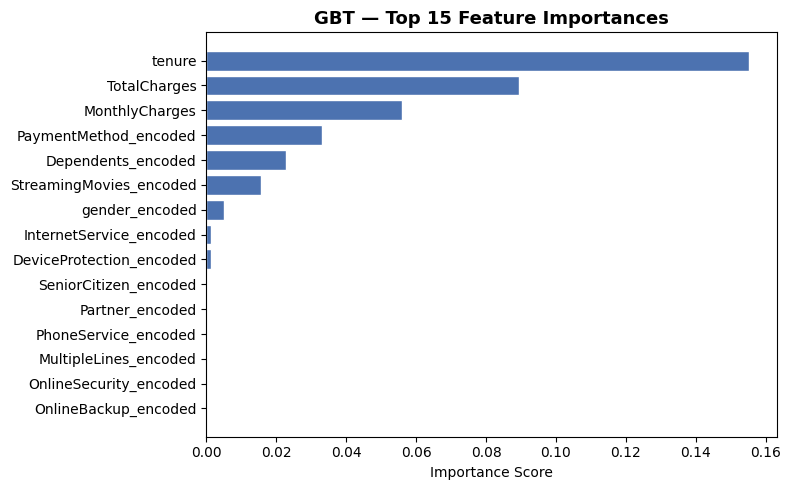


Top 5 features:
  tenure                         0.1554
  TotalCharges                   0.0894
  MonthlyCharges                 0.0559
  PaymentMethod_encoded          0.0331
  Dependents_encoded             0.0227


In [32]:
import matplotlib.pyplot as plt

# Reconstruct feature names in the order VectorAssembler used them
feature_names = num_cols + encoded_cols

importances = best_gbt.featureImportances.toArray()

# Pair names and importances, sort descending
feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
top_n = 15
names_top, vals_top = zip(*feat_imp[:top_n])

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(names_top[::-1], vals_top[::-1], color='#4c72b0', edgecolor='white')
ax.set_title(f'GBT — Top {top_n} Feature Importances', fontsize=13, fontweight='bold')
ax.set_xlabel('Importance Score')
plt.tight_layout()
plt.show()

print(f"\nTop 5 features:")
for name, val in feat_imp[:5]:
    print(f"  {name:<30} {val:.4f}")

---

## Phase 6: Data Visualization with Seaborn

*Since PySpark has no native plotting, we aggregate data in Spark, convert small results to Pandas, then plot with Seaborn/Matplotlib.*

> ⚠️ **Rule:** we call `.toPandas()` on small, already-aggregated DataFrames, never on the full raw dataset.

### Imports & Style Setup

In [36]:
!pip install -q matplotlib
!pip install -q seaborn

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 110

### 6.1. Churn Distribution (Bar Plot)

How balanced is our target variable?

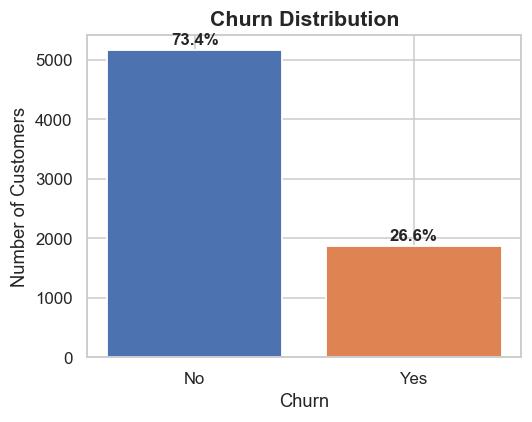

Churn  count       pct
   No   5163 73.421502
  Yes   1869 26.578498


In [38]:
churn_dist = df_clean.groupBy('Churn').count().toPandas()
churn_dist['pct'] = churn_dist['count'] / churn_dist['count'].sum() * 100

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(churn_dist['Churn'], churn_dist['count'],
              color=['#4c72b0', '#dd8452'], edgecolor='white', linewidth=1.2)
for bar, (_, row) in zip(bars, churn_dist.iterrows()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f"{row['pct']:.1f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_title('Churn Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Churn'); ax.set_ylabel('Number of Customers')
plt.tight_layout(); plt.show()
print(churn_dist.to_string(index=False))

### 6.2. Tenure vs. Churn (Box Plot)

Churned customers tend to have much shorter tenures — let's confirm visually.

C:\Users\pc\AppData\Local\Temp\ipykernel_22536\395277778.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tenure_pd, x='Churn', y='tenure',


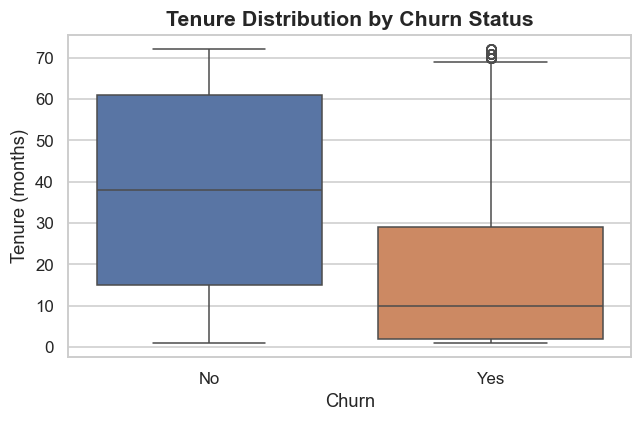

In [40]:
tenure_pd = df_clean.select('tenure', 'Churn').toPandas()

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=tenure_pd, x='Churn', y='tenure',
            palette={'No': '#4c72b0', 'Yes': '#dd8452'}, ax=ax)
ax.set_title('Tenure Distribution by Churn Status', fontsize=14, fontweight='bold')
ax.set_xlabel('Churn'); ax.set_ylabel('Tenure (months)')
plt.tight_layout(); plt.show()

### 6.3. Contract Type vs. Churn (Count Plot)

Month-to-month contracts have dramatically higher churn — a key business insight.

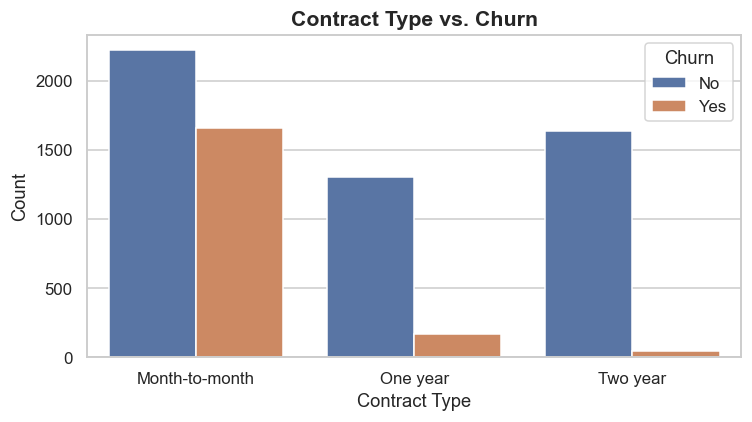

In [41]:
contract_pd = df_clean.select('Contract', 'Churn').toPandas()

fig, ax = plt.subplots(figsize=(7, 4))
sns.countplot(data=contract_pd, x='Contract', hue='Churn',
              palette={'No': '#4c72b0', 'Yes': '#dd8452'}, ax=ax)
ax.set_title('Contract Type vs. Churn', fontsize=14, fontweight='bold')
ax.set_xlabel('Contract Type'); ax.set_ylabel('Count')
ax.legend(title='Churn')
plt.tight_layout(); plt.show()

### 6.4. Monthly Charges by Churn (Violin Plot)

Churned customers tend to pay higher monthly charges — likely due to fiber optic plans.

C:\Users\pc\AppData\Local\Temp\ipykernel_22536\2101092500.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=charges_pd, x='Churn', y='MonthlyCharges',


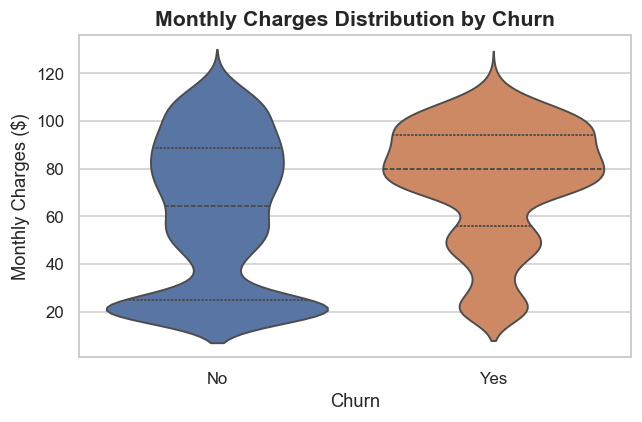

In [42]:
charges_pd = df_clean.select('MonthlyCharges', 'Churn').toPandas()

fig, ax = plt.subplots(figsize=(6, 4))
sns.violinplot(data=charges_pd, x='Churn', y='MonthlyCharges',
               palette={'No': '#4c72b0', 'Yes': '#dd8452'}, inner='quartile', ax=ax)
ax.set_title('Monthly Charges Distribution by Churn', fontsize=14, fontweight='bold')
ax.set_xlabel('Churn'); ax.set_ylabel('Monthly Charges ($)')
plt.tight_layout(); plt.show()

### 6.5. Churn Rate by Internet Service Type (Horizontal Bar)

Fiber optic customers churn at ~42% — far above DSL and no-internet customers.

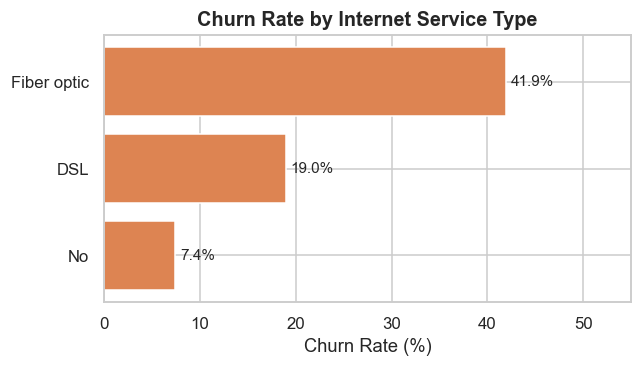

In [43]:
inet_churn = df_clean.groupBy('InternetService').agg(
    F.count('*').alias('total'),
    F.sum(F.when(F.col('Churn') == 'Yes', 1).otherwise(0)).alias('churned')
).withColumn('churn_rate', F.col('churned') / F.col('total') * 100).toPandas()
inet_churn = inet_churn.sort_values('churn_rate', ascending=True)

fig, ax = plt.subplots(figsize=(6, 3.5))
bars = ax.barh(inet_churn['InternetService'], inet_churn['churn_rate'],
               color='#dd8452', edgecolor='white')
for bar, val in zip(bars, inet_churn['churn_rate']):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2,
            f"{val:.1f}%", va='center', fontsize=10)
ax.set_title('Churn Rate by Internet Service Type', fontsize=13, fontweight='bold')
ax.set_xlabel('Churn Rate (%)'); ax.set_xlim(0, 55)
plt.tight_layout(); plt.show()

### 6.6. Payment Method vs. Churn Rate (Grouped Bar)

Electronic check users churn at the highest rate — a useful signal for targeted retention.

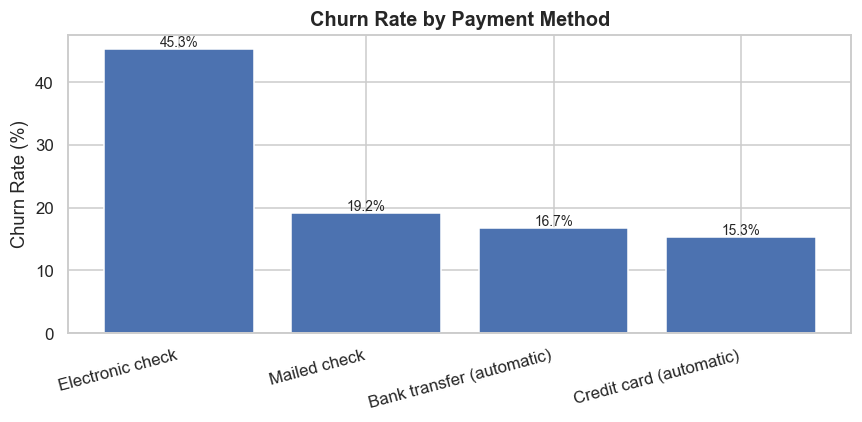

In [44]:
pay_churn = df_clean.groupBy('PaymentMethod').agg(
    F.count('*').alias('total'),
    F.sum(F.when(F.col('Churn') == 'Yes', 1).otherwise(0)).alias('churned')
).withColumn('churn_rate', F.col('churned') / F.col('total') * 100).toPandas()
pay_churn = pay_churn.sort_values('churn_rate', ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(pay_churn['PaymentMethod'], pay_churn['churn_rate'],
              color='#4c72b0', edgecolor='white')
for bar, val in zip(bars, pay_churn['churn_rate']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.4,
            f"{val:.1f}%", ha='center', fontsize=9)
ax.set_title('Churn Rate by Payment Method', fontsize=13, fontweight='bold')
ax.set_ylabel('Churn Rate (%)')
plt.xticks(rotation=15, ha='right')
plt.tight_layout(); plt.show()

---

### End of Notebook

In [45]:
# Stop the Spark session
spark.stop()
print("SparkSession stopped.")

SparkSession stopped.
